# camels script testing - geology attributes

In [2]:
%matplotlib inline  
import os, sys
import glob
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import scripts.utility as util

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


## Reading LiMW2015 and GLHYMPS geopackage data

In [3]:
catchment_name = 'camels' #  CONUS_HUC12 or camels
saveCSV = True
saveNetCDF = True

In [4]:
src_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/geology'
LiMW2015_gpkg_list = [os.path.join(src_dir, 'LiMW2015_North_America_WGS84.gpkg')]
GLHYMPS_gpkg_list = [os.path.join(src_dir, 'GLHYMPS_North_America_WGS84.gpkg')]

# camels basin
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg' #HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg
LiMW2015_mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_LiMW2015_to_camels.nc'
GLHYMPS_mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_GLHYMPS_to_camels.nc'
# HUC12
#gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg'
#LiMW2015_mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_LiMW2015_to_CONUS_HUC12.nc'
#GLHYMPS_mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_GLHYMPS_to_CONUS_HUC12.nc'


In [5]:
# netcdf header: variable name
LiMW2015_attr_dict = {
    'OBJECTID':'numeric polygon ID',
    'IDENTITY_':'ID',
    'xx':'The first level lithological class ',
}

GLHYMPS_attr_dict = {
    'OBJECTID':'numeric polygon ID',
    'IDENTITY_':'ID',
    'Porosity':'subsurface porosity',
    'Permeability_permafrost':'near-surface permeability (log10) with permafrost effects',
    'Permeability_no_permafrost':'near-surface permeability (log10) neglecting permafrost effects'
} # use Permeability_permafrost

In [6]:
# target catchment attribute
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['GAGE_ID']
}

In [7]:
GLiM_class = {
    "su":{"class":"Unconsolidated sediments", "color":"lightgoldenrod1"},
    "ss":{"class":"Siliciclastic sedimentary rocks", "color":"goldenrod"},
    "sm":{"class":"Mixed sedimentary rocks", "color":"burlywood4"},
    "py":{"class":"Pyroclastics", "color":"tan4"},
    "sc":{"class":"Carbonate sedimentary rocks", "color":"steelblue3"},
    "ev":{"class":"Evaporites", "color":"olivedrab1"},
    "mt":{"class":"Metamorphics", "color":"palegreen3"},
    "pa":{"class":"Acid plutonic rocks", "color":"brown3"},
    "pi":{"class":"Intermediate plutonic rocks", "color":"violetred4"},
    "pb":{"class":"Basic plutonic rocks", "color":"purple4"},
    "va":{"class":"Acid volcanic rocks", "color":"pink"},
    "vi":{"class":"Intermediate volcanic rocks", "color":"orchid2"},
    "vb":{"class":"Basic volcanic rocks", "color":"magenta3"},
    "ig":{"class":"Ice and glaciers", "color":"paleturquoise1"},
    "wb":{"class":"Water bodies", "color":"turquoise2"},
    "nd":{"class":"No Data", "color":"slategray"},
}

In [8]:
%%time
print(f'Reading LiMW2015 geology data')
gdf_LiMW2015 = util.read_shps(LiMW2015_gpkg_list,list(LiMW2015_attr_dict.keys()))
ds_LiMW2015 = gdf_LiMW2015.rename(columns={'OBJECTID':'hru'}).set_index('hru').to_xarray()
ds_LiMW2015 = ds_LiMW2015.rename({'xx':'lithological_class'})
ds_LiMW2015['carbonate_rock'] = xr.DataArray(np.ones(len(ds_LiMW2015['hru']), dtype=int), dims=ds_LiMW2015.dims, coords=ds_LiMW2015.coords)
ds_LiMW2015['carbonate_rock'] = ds_LiMW2015['carbonate_rock'].where(ds_LiMW2015['lithological_class']=='sc', 0)
ds_LiMW2015

Reading LiMW2015 geology data
Finished reading /glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/geology/LiMW2015_North_America_WGS84.gpkg
CPU times: user 1min 18s, sys: 2.19 s, total: 1min 20s
Wall time: 1min 24s


<xarray.Dataset> Size: 20MB
Dimensions:             (hru: 497220)
Coordinates:
  * hru                 (hru) int64 4MB 424364 424365 424366 ... 921582 921583
Data variables:
    geometry            (hru) object 4MB MULTIPOLYGON (((-113.22082888947894 ...
    IDENTITY_           (hru) object 4MB 'USA_UT21000' ... 'NA1033'
    lithological_class  (hru) object 4MB 'vb' 'ss' 'su' 'ss' ... 'wb' 'wb' 'wb'
    carbonate_rock      (hru) int64 4MB 0 0 0 0 1 0 1 0 0 ... 0 0 0 0 0 0 0 0 0

In [9]:
%%time
print(f'Reading GLHYMPS geology data')
gdf_GLHYMPS = util.read_shps(GLHYMPS_gpkg_list,list(GLHYMPS_attr_dict.keys()))
ds_GLHYMPS = gdf_GLHYMPS.rename(columns={'OBJECTID':'hru'}).set_index('hru').to_xarray()
ds_GLHYMPS

Reading GLHYMPS geology data
Finished reading /glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/geology/GLHYMPS_North_America_WGS84.gpkg
CPU times: user 1min 35s, sys: 2.15 s, total: 1min 37s
Wall time: 1min 42s


<xarray.Dataset> Size: 26MB
Dimensions:                     (hru: 550003)
Coordinates:
  * hru                         (hru) int64 4MB 386084 386085 ... 1344579
Data variables:
    geometry                    (hru) object 4MB MULTIPOLYGON (((-155.8637483...
    IDENTITY_                   (hru) object 4MB 'USA_HI6108' ... 'CAN56'
    Porosity                    (hru) float64 4MB 0.09 0.09 0.09 ... 0.19 0.01
    Permeability_permafrost     (hru) float64 4MB -12.5 -12.5 ... -15.2 -14.1
    Permeability_no_permafrost  (hru) float64 4MB -12.5 -12.5 ... -15.2 -14.1

## Re-mapping
- 1st dominant class
- 2nd cominant class
- porosity
- Permeability

In [10]:
%%time
dr_mask = xr.where(np.isnan(ds_LiMW2015['carbonate_rock']),0,1)
a = util.remap_mode(xr.open_dataset(LiMW2015_mapping_file), ds_LiMW2015, dr_mask, ['lithological_class'])
a['1st_dominant_lithological_class_fraction'] = a['1st_dominant_lithological_class_fraction'].where(a['1st_dominant_lithological_class']!='N/A', 0)
a['2nd_dominant_lithological_class_fraction'] = a['2nd_dominant_lithological_class_fraction'].where(a['2nd_dominant_lithological_class']!='N/A', 0)

Averaging areas for 671 polygons: 
-------------------
  averaged lithological_class
CPU times: user 1.58 s, sys: 191 ms, total: 1.77 s
Wall time: 2.03 s


In [11]:
%%time
# carbonate rock fraction
a1 = util.remap_mean(xr.open_dataset(LiMW2015_mapping_file), ds_LiMW2015, dr_mask, ['carbonate_rock'])
a = xr.merge([a, a1['carbonate_rock'].rename('carbonate_rock_frac')])

Averaging areas for 671 polygons: 
-------------------
  averaged carbonate_rock
CPU times: user 109 ms, sys: 3.91 ms, total: 113 ms
Wall time: 116 ms


In [12]:
%%time
dr_mask = xr.where(np.isnan(ds_GLHYMPS['Porosity']),0,1)
a1 = util.remap_mean(xr.open_dataset(GLHYMPS_mapping_file), ds_GLHYMPS, dr_mask, ['Porosity', 'Permeability_permafrost'])
a = xr.merge([a, a1])
a

Averaging areas for 671 polygons: 
-------------------
  averaged Porosity
-------------------
  averaged Permeability_permafrost
CPU times: user 126 ms, sys: 4.01 ms, total: 130 ms
Wall time: 135 ms


<xarray.Dataset> Size: 59kB
Dimensions:                                   (hru: 671)
Coordinates:
  * hru                                       (hru) <U8 21kB '01013500' ... '...
Data variables:
    1st_dominant_lithological_class           (hru) object 5kB 'ss' ... 'vb'
    2nd_dominant_lithological_class           (hru) object 5kB 'vb' ... 'su'
    1st_dominant_lithological_class_fraction  (hru) float64 5kB 0.8088 ... 0....
    2nd_dominant_lithological_class_fraction  (hru) float64 5kB 0.187 ... 0.1281
    carbonate_rock_frac                       (hru) float64 5kB 0.0 0.0 ... 0.0
    Porosity                                  (hru) float64 5kB 0.1706 ... 0....
    Permeability_permafrost                   (hru) float64 5kB -14.69 ... -12.3

## Dataset to Dataframe

In [13]:
df = a.to_dataframe()

## Save in csv or netcdf

In [14]:
if saveCSV:
    df.to_csv(f'{catchment_name}_geol.csv', float_format='%g')
if saveNetCDF:
    a.to_netcdf(f'{catchment_name}_geol.nc')

## Plotting

In [15]:
%%time
gdf_camels = util.read_shps([gpkg],catch_attrs[catchment_name])

Finished reading /glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg
CPU times: user 5.86 s, sys: 77.5 ms, total: 5.93 s
Wall time: 6.64 s


In [16]:
gdf_camels = gdf_camels.merge(a[['2nd_dominant_lithological_class',
                                 '2nd_dominant_lithological_class_fraction',
                                 '1st_dominant_lithological_class', 
                                 '1st_dominant_lithological_class_fraction',
                                 'carbonate_rock_frac',
                                 'Porosity', 
                                 'Permeability_permafrost']].to_dataframe(),left_on=catch_attrs[catchment_name], right_index=True)

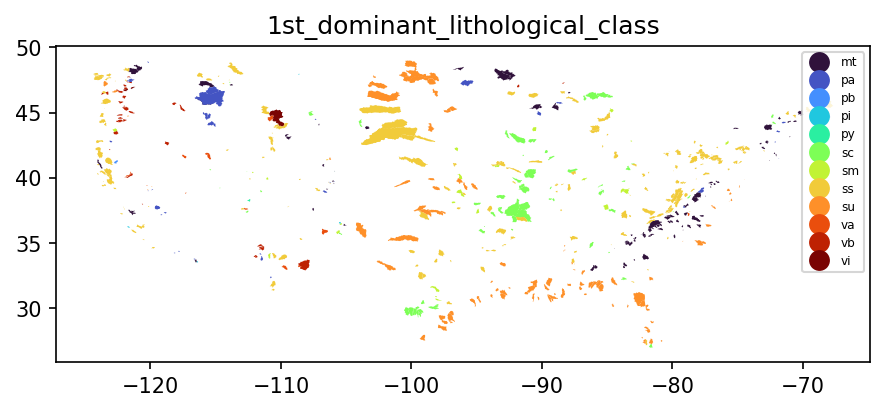

In [17]:
var_name = '1st_dominant_lithological_class'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                legend=True, legend_kwds={'fontsize':'xx-small','loc':'best'},
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_geol_{var_name}.png', dpi=300)

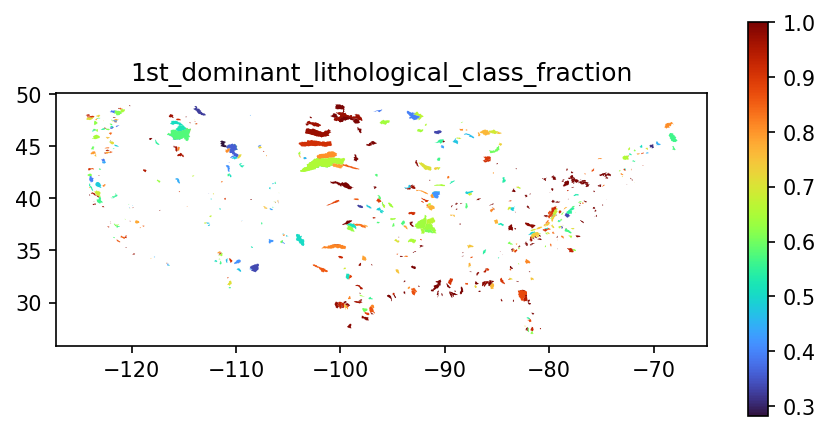

In [18]:
var_name = '1st_dominant_lithological_class_fraction'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_geol_{var_name}.png', dpi=300)

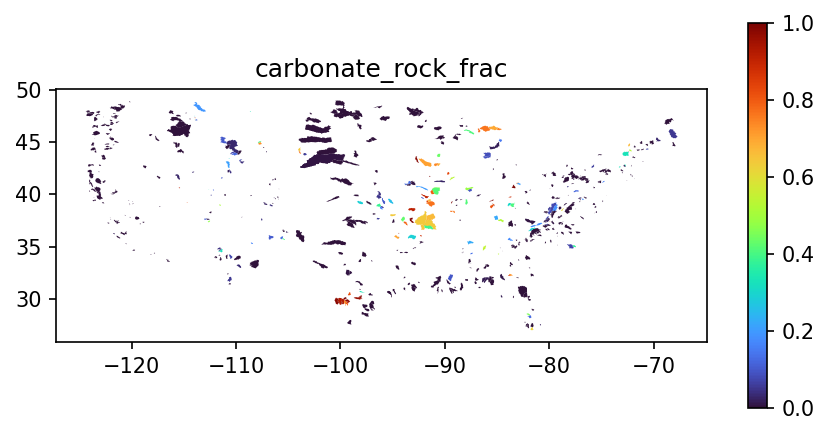

In [19]:
var_name = 'carbonate_rock_frac'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_geol_{var_name}.png', dpi=300)

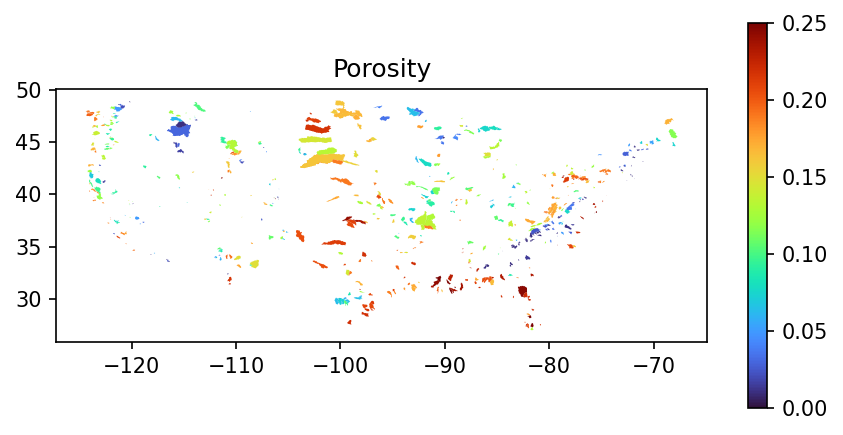

In [20]:
var_name = 'Porosity'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 0.25),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_geol_{var_name}.png', dpi=300)

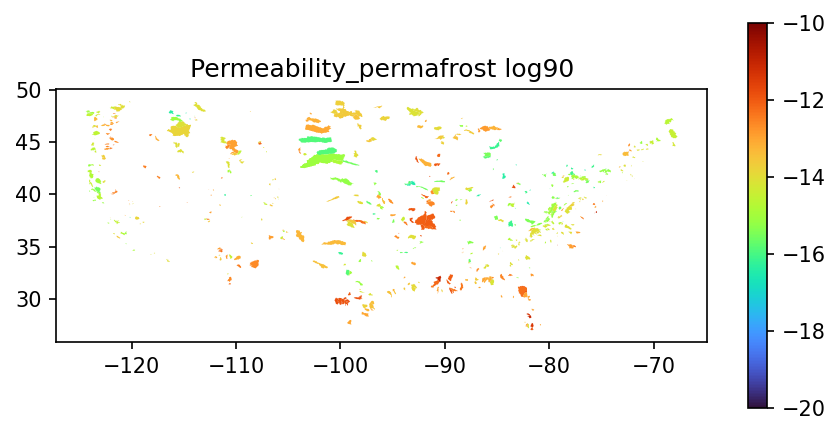

In [21]:
var_name = 'Permeability_permafrost'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-20, -10),
                legend=True
               );
ax.set_title(f'{var_name} log90');
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_geol_{var_name}.png', dpi=300)